In [ ]:
# Evaluation metric
# score = 100*max(0, 1-metrics.mean_squared_log_error(actual, predicted))

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import f1_score, roc_auc_score
from xgboost import XGBRegressor
import random
import pandas_profiling
from pycaret.regression import setup, compare_models, create_model, tune_model

In [2]:
train_df = pd.read_csv('train.csv')
train_df['type'] = 'train'
test_df = pd.read_csv('test.csv')
test_df['type'] = 'test'
df = pd.concat([train_df, test_df], axis = 0)
df.head()

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"New Michelle, OH 50777",-283.29,train
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"New Michaelport, WY 12072",-159.96,train
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,"Bowmanshire, WA 19241",-154.29,train
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"East Robyn, KY 86375",-161.16,train
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,"Aprilside, PA 52793",-159.23,train


In [3]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Id            6500 non-null   object 
 1   Artist Name            6500 non-null   object 
 2   Artist Reputation      5750 non-null   float64
 3   Height                 6125 non-null   float64
 4   Width                  5916 non-null   float64
 5   Weight                 5913 non-null   float64
 6   Material               5736 non-null   object 
 7   Price Of Sculpture     6500 non-null   float64
 8   Base Shipping Price    6500 non-null   float64
 9   International          6500 non-null   object 
 10  Express Shipment       6500 non-null   object 
 11  Installation Included  6500 non-null   object 
 12  Transport              5108 non-null   object 
 13  Fragile                6500 non-null   object 
 14  Customer Information   6500 non-null   object 
 15  Remo

In [4]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3500 entries, 0 to 3499
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Id            3500 non-null   object 
 1   Artist Name            3500 non-null   object 
 2   Artist Reputation      3278 non-null   float64
 3   Height                 3381 non-null   float64
 4   Width                  3359 non-null   float64
 5   Weight                 3351 non-null   float64
 6   Material               3500 non-null   object 
 7   Price Of Sculpture     3500 non-null   float64
 8   Base Shipping Price    3500 non-null   float64
 9   International          3500 non-null   object 
 10  Express Shipment       3500 non-null   object 
 11  Installation Included  3500 non-null   object 
 12  Transport              3268 non-null   object 
 13  Fragile                3500 non-null   object 
 14  Customer Information   3500 non-null   object 
 15  Remo

In [5]:
train_df.describe()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,Cost
count,5750.000000,6125.000000,5916.000000,5.913000e+03,6500.00000,6500.000000,6.500000e+03
mean,0.461850,21.766204,9.617647,4.006948e+05,1192.42009,37.407174,1.713920e+04
std,0.265781,11.968192,5.417000,2.678081e+06,8819.61675,26.873519,2.406579e+05
min,0.000000,3.000000,2.000000,3.000000e+00,3.00000,10.000000,-8.801727e+05
25%,0.240000,12.000000,6.000000,5.030000e+02,5.23000,16.700000,1.884400e+02
50%,0.450000,20.000000,8.000000,3.102000e+03,8.02500,23.505000,3.820650e+02
75%,0.680000,30.000000,12.000000,3.645600e+04,89.47000,57.905000,1.156115e+03
max,1.000000,73.000000,50.000000,1.179279e+08,382385.67000,99.980000,1.114343e+07


 - One point to note that schedule and delivery dates can be transformed into another variables knowing their importance

# Dropping id and name

In [6]:
df.drop(['Customer Id', 'Artist Name'], axis = 1, inplace = True)

In [7]:
columns = df.columns
for col in columns:
    print(col, 'has', df[col].nunique(), 'unique values')

Artist Reputation has 101 unique values
Height has 66 unique values
Width has 42 unique values
Weight has 6320 unique values
Material has 7 unique values
Price Of Sculpture has 4813 unique values
Base Shipping Price has 4744 unique values
International has 2 unique values
Express Shipment has 2 unique values
Installation Included has 2 unique values
Transport has 3 unique values
Fragile has 2 unique values
Customer Information has 2 unique values
Remote Location has 2 unique values
Scheduled Date has 1697 unique values
Delivery Date has 1699 unique values
Customer Location has 9999 unique values
Cost has 6356 unique values
type has 2 unique values


# EDA...

### Checking distribution of Target as it is continuous

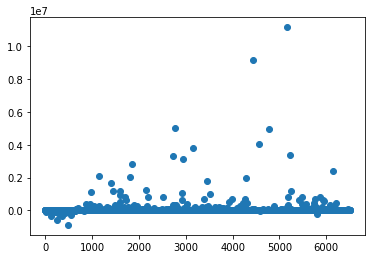

In [8]:
plt.scatter(train_df.index, train_df['Cost'])

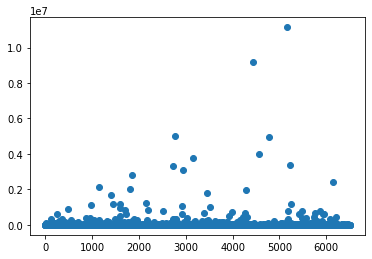

In [9]:
cost = abs(train_df['Cost'])
plt.scatter(train_df.index, cost)

<AxesSubplot:ylabel='Density'>

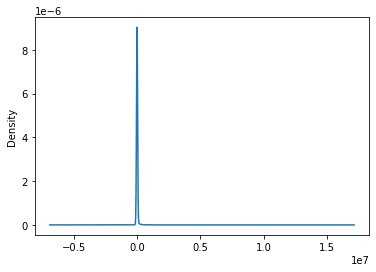

In [10]:
train_df['Cost'].plot(kind = 'density')

<AxesSubplot:xlabel='Cost'>

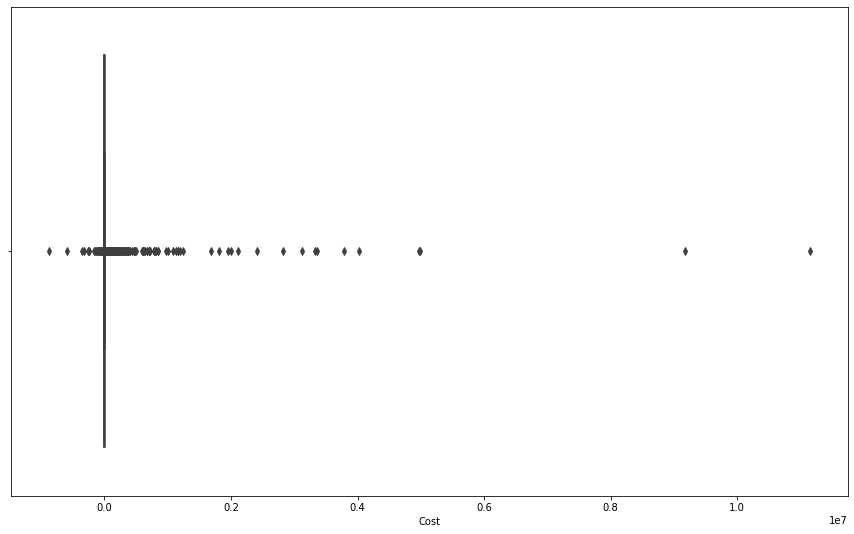

In [11]:
plt.figure(figsize = (15,9))
sns.boxplot(train_df['Cost'])

<AxesSubplot:xlabel='Cost', ylabel='Density'>

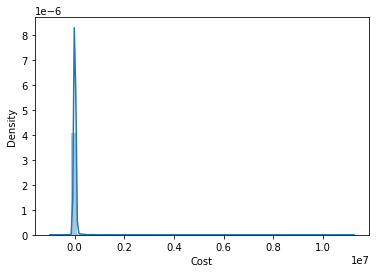

In [12]:
sns.distplot(train_df['Cost'])

In [13]:
train_df[train_df['Cost'] > 100000]

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type
706,fffe3900340032003500,Eddie Hall,0.79,18.0,15.0,925577.0,Stone,6009.33,52.65,Yes,No,No,Airways,No,Working Class,No,11/18/18,11/20/18,"East Paula, UT 78707",147868.28,train
876,fffe3200330039003400,Joanne Lynn,0.63,26.0,16.0,974277.0,NaN,9421.74,85.69,Yes,No,No,Waterways,No,Working Class,Yes,01/22/16,01/25/16,APO AP 46289,388110.79,train
895,fffe3900390032003000,Jose Wyatt,0.22,32.0,24.0,14616806.0,Stone,54192.73,44.21,Yes,No,Yes,Waterways,No,Working Class,No,05/07/19,05/03/19,"North Loribury, PA 70048",163991.29,train
950,fffe3400310031003900,Louise Carpenter,0.63,32.0,23.0,12247852.0,Stone,57641.13,87.58,Yes,No,No,Waterways,No,Working Class,No,07/01/18,07/03/18,"Jennifermouth, FL 38583",404774.73,train
974,fffe3100360034003500,Deidre Caron,0.54,28.0,18.0,4450354.0,NaN,11133.30,67.20,Yes,Yes,No,NaN,No,Wealthy,Yes,05/24/15,05/24/15,"North Samuelborough, AR 43186",104097.16,train
982,fffe3300360039003900,Craig Vantull,0.87,NaN,20.0,NaN,Stone,56248.47,53.53,Yes,No,Yes,Waterways,No,Working Class,No,09/11/16,09/12/16,"East Samantha, IA 21808",1135562.39,train
1001,fffe3700320032003000,Joella Willis,0.66,30.0,15.0,2814033.0,Stone,16439.28,34.99,No,Yes,Yes,Airways,No,Working Class,No,05/24/18,05/28/18,APO AE 82918,112404.52,train
1031,fffe330038003500,Mary Lee,0.46,33.0,18.0,5400692.0,Stone,7404.87,84.07,Yes,Yes,Yes,NaN,No,Wealthy,Yes,12/23/15,12/24/15,"South Michaelborough, SC 81022",250725.10,train
1084,fffe3200390031003000,Danielle Barnard,0.82,39.0,15.0,1112447.0,Marble,5408.58,76.80,No,No,Yes,Airways,Yes,Wealthy,No,03/24/18,03/20/18,"East Matthew, ID 22490",128411.71,train
1098,fffe3900380032003000,Brent Laban,0.87,19.0,8.0,242570.0,Stone,935.05,91.34,No,No,No,Roadways,No,Working Class,No,06/13/19,06/13/19,"West Katherineshire, AR 09983",158418.20,train


In [14]:
df['Cost'] = df['Cost'].apply(lambda x: abs(x))
train_df['Cost'] = train_df['Cost'].apply(lambda x: abs(x))

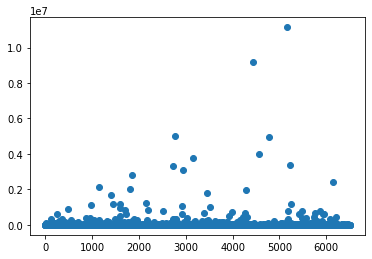

In [15]:
plt.scatter(train_df.index, train_df['Cost'])

# Checking Missing values

<AxesSubplot:>

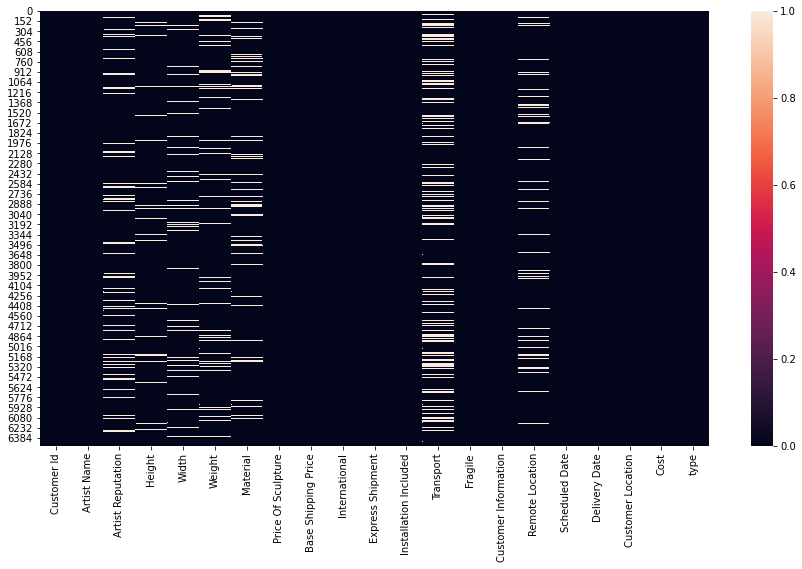

In [16]:
plt.figure(figsize = (15, 8))
sns.heatmap(train_df.isnull())

In [18]:
for col in train_df.columns:
    print(col, 'has', sum(train_df[col].isnull())*100/len(train_df), '% missing values')

Customer Id has 0.0 % missing values
Artist Name has 0.0 % missing values
Artist Reputation has 11.538461538461538 % missing values
Height has 5.769230769230769 % missing values
Width has 8.984615384615385 % missing values
Weight has 9.03076923076923 % missing values
Material has 11.753846153846155 % missing values
Price Of Sculpture has 0.0 % missing values
Base Shipping Price has 0.0 % missing values
International has 0.0 % missing values
Express Shipment has 0.0 % missing values
Installation Included has 0.0 % missing values
Transport has 21.415384615384614 % missing values
Fragile has 0.0 % missing values
Customer Information has 0.0 % missing values
Remote Location has 11.861538461538462 % missing values
Scheduled Date has 0.0 % missing values
Delivery Date has 0.0 % missing values
Customer Location has 0.0 % missing values
Cost has 0.0 % missing values
type has 0.0 % missing values


# Checking the distribution of missing features and imputing a relevant value (we can also check the importance of variables) 

<AxesSubplot:xlabel='Artist Reputation', ylabel='Density'>

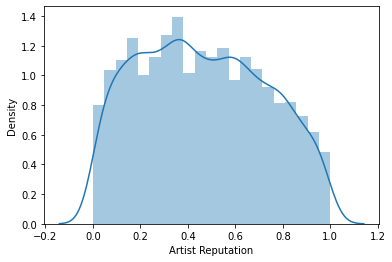

In [19]:
columns = ['Artist Reputation', 'Height', 'Width', 'Material', 'Transport', 'Remote Location']
sns.distplot(train_df['Artist Reputation'])

<AxesSubplot:xlabel='Height', ylabel='Density'>

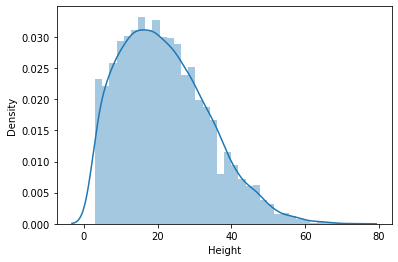

In [20]:
sns.distplot(train_df['Height'])

<AxesSubplot:xlabel='Width', ylabel='Density'>

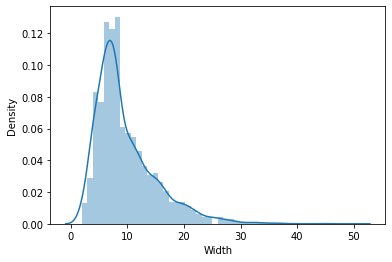

In [21]:
sns.distplot(train_df['Width'])

<AxesSubplot:xlabel='Material', ylabel='count'>

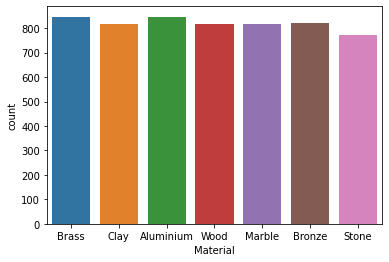

In [22]:
sns.countplot(train_df['Material'])

<AxesSubplot:xlabel='Transport', ylabel='count'>

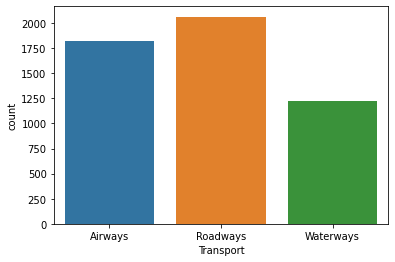

In [23]:
sns.countplot(train_df['Transport'])

<AxesSubplot:xlabel='Remote Location', ylabel='count'>

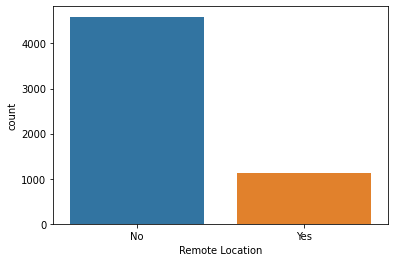

In [24]:
sns.countplot(train_df['Remote Location'])

# Missing Value Imputation

In [25]:
df['Remote Location'].fillna('No', inplace = True)
df['Transport'].fillna('Roadways Transport', inplace = True)
df['Material'].fillna('Brass', inplace = True)
df['Width'].fillna(df['Width'].median(), inplace = True)
df['Height'].fillna(df['Width'].median(), inplace = True)
df['Artist Reputation'].fillna(df['Artist Reputation'].median(), inplace = True)
df['Weight'].fillna(df['Weight'].median(), inplace = True)

<AxesSubplot:>

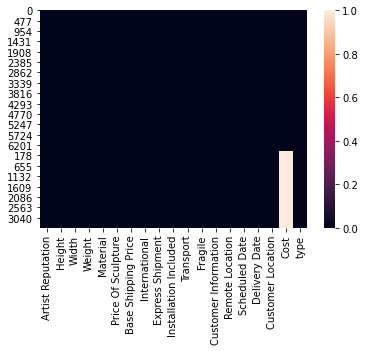

In [26]:
sns.heatmap(df.isnull())

In [27]:
for col in df.columns:
    if df[col].dtype != 'O':
        print('skewness of', col, 'is', train_df[col].skew())

skewness of Artist Reputation is 0.14136319809827527
skewness of Height is 0.5940405867976738
skewness of Width is 1.5467020508131184
skewness of Weight is 21.55617438905673
skewness of Price Of Sculpture is 22.20682307949474
skewness of Base Shipping Price is 0.9181023776582664
skewness of Cost is 29.86640618935751


# Univariate Analysis

In [28]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6500 entries, 0 to 6499
Data columns (total 21 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Customer Id            6500 non-null   object 
 1   Artist Name            6500 non-null   object 
 2   Artist Reputation      5750 non-null   float64
 3   Height                 6125 non-null   float64
 4   Width                  5916 non-null   float64
 5   Weight                 5913 non-null   float64
 6   Material               5736 non-null   object 
 7   Price Of Sculpture     6500 non-null   float64
 8   Base Shipping Price    6500 non-null   float64
 9   International          6500 non-null   object 
 10  Express Shipment       6500 non-null   object 
 11  Installation Included  6500 non-null   object 
 12  Transport              5108 non-null   object 
 13  Fragile                6500 non-null   object 
 14  Customer Information   6500 non-null   object 
 15  Remo

<AxesSubplot:xlabel='Artist Reputation', ylabel='Density'>

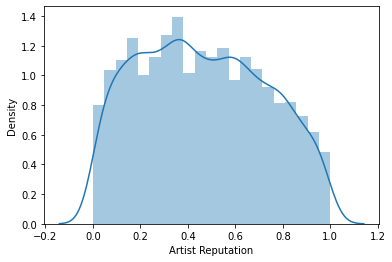

In [29]:
sns.distplot(train_df['Artist Reputation'])

<AxesSubplot:xlabel='Height', ylabel='Density'>

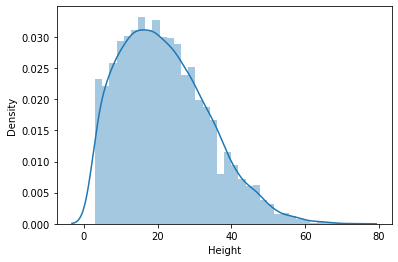

In [30]:
sns.distplot(train_df['Height'])

<AxesSubplot:xlabel='Weight', ylabel='Density'>

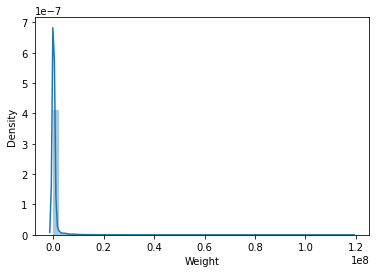

In [31]:
sns.distplot(train_df['Weight'])

<AxesSubplot:xlabel='Width', ylabel='Density'>

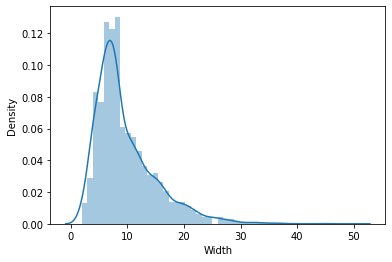

In [32]:
sns.distplot(train_df['Width'])

<AxesSubplot:xlabel='Material', ylabel='count'>

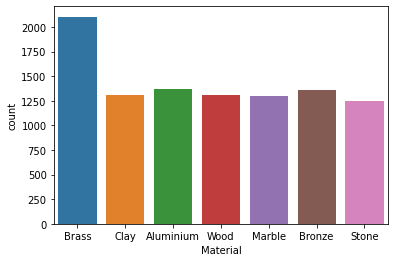

In [33]:
sns.countplot(df['Material'])

In [80]:
# Performing this so that we can label encode the material
train_df.groupby('Material')['Cost'].mean()

Material
Aluminium      370.025870
Brass         1780.499233
Bronze        1381.845981
Clay           609.222684
Marble       38598.012210
Stone        87189.701412
Wood           299.311483
Name: Cost, dtype: float64

<AxesSubplot:xlabel='Price Of Sculpture', ylabel='Density'>

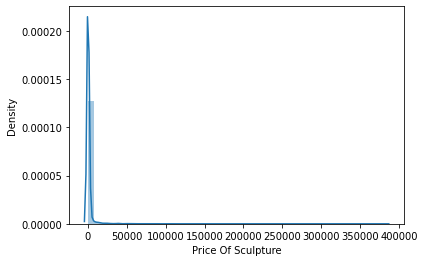

In [34]:
sns.distplot(train_df['Price Of Sculpture'])

<AxesSubplot:xlabel='Price Of Sculpture'>

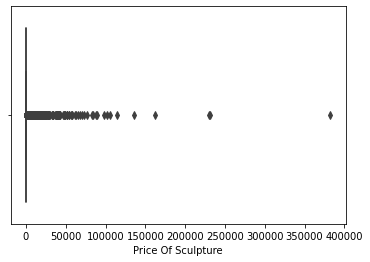

In [35]:
sns.boxplot(train_df['Price Of Sculpture'])

<AxesSubplot:xlabel='Base Shipping Price', ylabel='Density'>

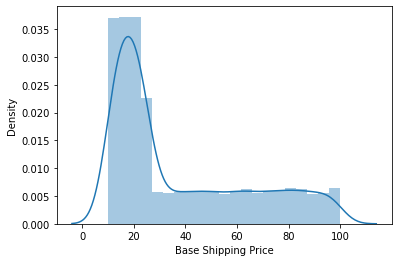

In [36]:
sns.distplot(train_df['Base Shipping Price'])

<AxesSubplot:xlabel='International', ylabel='count'>

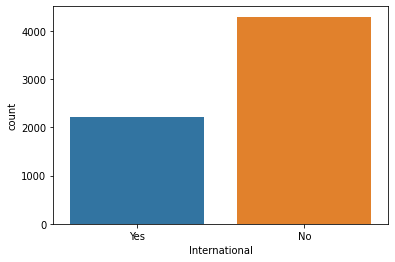

In [37]:
sns.countplot(train_df['International'])

<AxesSubplot:xlabel='Express Shipment', ylabel='count'>

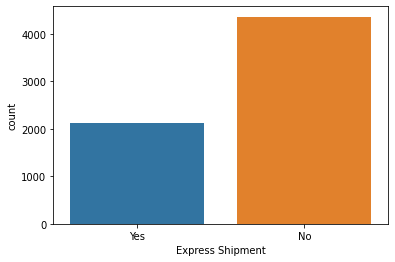

In [38]:
sns.countplot(train_df['Express Shipment'])

<AxesSubplot:xlabel='Installation Included', ylabel='count'>

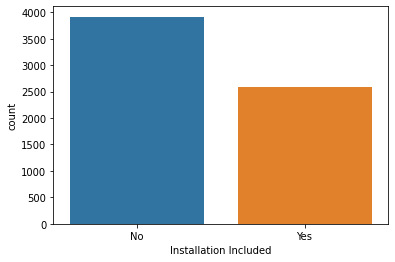

In [39]:
sns.countplot(train_df['Installation Included'])

<AxesSubplot:xlabel='Transport', ylabel='count'>

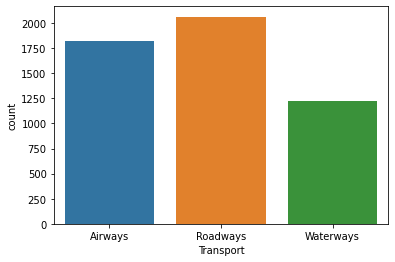

In [40]:
sns.countplot(train_df['Transport'])

<AxesSubplot:xlabel='Fragile', ylabel='count'>

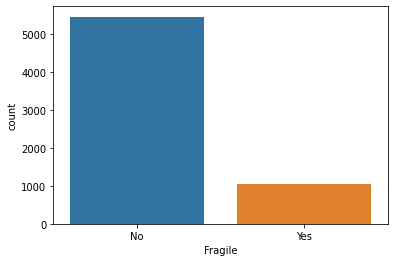

In [41]:
sns.countplot(train_df['Fragile'])

<AxesSubplot:xlabel='Customer Information', ylabel='count'>

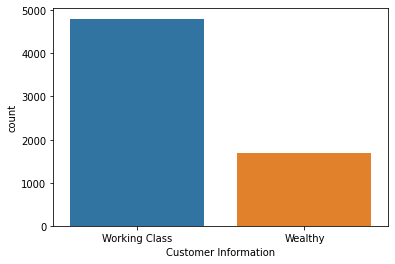

In [42]:
sns.countplot(train_df['Customer Information'])

<AxesSubplot:xlabel='Remote Location', ylabel='count'>

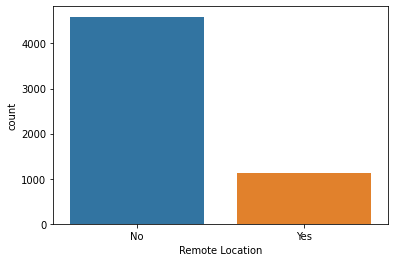

In [43]:
sns.countplot(train_df['Remote Location'])

# Correlation

<AxesSubplot:>

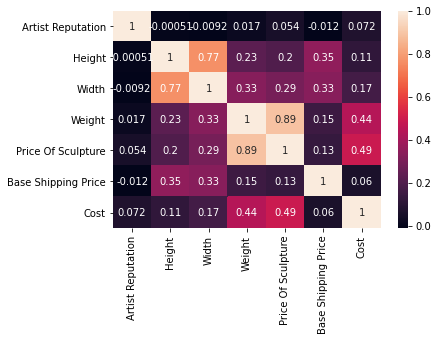

In [44]:
sns.heatmap(train_df.corr(), annot=True)

In [45]:
df.replace({'Yes': 0, 'No': 1}, inplace=True)

In [46]:
df.dtypes

Artist Reputation        float64
Height                   float64
Width                    float64
Weight                   float64
Material                  object
Price Of Sculpture       float64
Base Shipping Price      float64
International              int64
Express Shipment           int64
Installation Included      int64
Transport                 object
Fragile                    int64
Customer Information      object
Remote Location            int64
Scheduled Date            object
Delivery Date             object
Customer Location         object
Cost                     float64
type                      object
dtype: object

# Converting Material into Vars

In [47]:
dummy_materials = pd.get_dummies(df['Material'], prefix = 'material')
dummy_materials

,material_Aluminium,material_Brass,material_Bronze,material_Clay,material_Marble,material_Stone,material_Wood
0,0,1,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,0,1,0,0,0
3,1,0,0,0,0,0,0
4,1,0,0,0,0,0,0
...,...,...,...,...,...,...,...
3495,0,0,0,0,1,0,0
3496,0,0,1,0,0,0,0
3497,0,1,0,0,0,0,0
3498,1,0,0,0,0,0,0


In [48]:
df = pd.concat([df, dummy_materials], axis = 1)
df = df.drop('Material', axis = 1)
df.head()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type,material_Aluminium,material_Brass,material_Bronze,material_Clay,material_Marble,material_Stone,material_Wood
0,0.26,17.0,6.0,4128.0,13.91,16.27,0,0,1,Airways,1,Working Class,1,06/07/15,06/03/15,"New Michelle, OH 50777",283.29,train,0,1,0,0,0,0,0
1,0.28,3.0,3.0,61.0,6.83,15.00,1,1,1,Roadways,1,Working Class,1,03/06/17,03/05/17,"New Michaelport, WY 12072",159.96,train,0,1,0,0,0,0,0
2,0.07,8.0,5.0,237.0,4.96,21.18,1,1,1,Roadways,0,Working Class,0,03/09/15,03/08/15,"Bowmanshire, WA 19241",154.29,train,0,0,0,1,0,0,0
3,0.12,9.0,8.0,3032.0,5.81,16.31,1,1,1,Roadways Transport,1,Wealthy,0,05/24/15,05/20/15,"East Robyn, KY 86375",161.16,train,1,0,0,0,0,0,0
4,0.15,17.0,6.0,324.0,3.18,11.94,0,0,0,Airways,1,Working Class,1,12/18/16,12/14/16,"Aprilside, PA 52793",159.23,train,1,0,0,0,0,0,0


In [49]:
dummy_transport = pd.get_dummies(df['Transport'], prefix = 'transport')
dummy_transport

,transport_Airways,transport_Roadways,transport_Roadways Transport,transport_Waterways
0,1,0,0,0
1,0,1,0,0
2,0,1,0,0
3,0,0,1,0
4,1,0,0,0
...,...,...,...,...
3495,1,0,0,0
3496,1,0,0,0
3497,1,0,0,0
3498,1,0,0,0


In [50]:
df = pd.concat([df, dummy_transport], axis = 1)
df = df.drop('Transport', axis = 1)
df.head()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type,material_Aluminium,material_Brass,material_Bronze,material_Clay,material_Marble,material_Stone,material_Wood,transport_Airways,transport_Roadways,transport_Roadways Transport,transport_Waterways
0,0.26,17.0,6.0,4128.0,13.91,16.27,0,0,1,1,Working Class,1,06/07/15,06/03/15,"New Michelle, OH 50777",283.29,train,0,1,0,0,0,0,0,1,0,0,0
1,0.28,3.0,3.0,61.0,6.83,15.00,1,1,1,1,Working Class,1,03/06/17,03/05/17,"New Michaelport, WY 12072",159.96,train,0,1,0,0,0,0,0,0,1,0,0
2,0.07,8.0,5.0,237.0,4.96,21.18,1,1,1,0,Working Class,0,03/09/15,03/08/15,"Bowmanshire, WA 19241",154.29,train,0,0,0,1,0,0,0,0,1,0,0
3,0.12,9.0,8.0,3032.0,5.81,16.31,1,1,1,1,Wealthy,0,05/24/15,05/20/15,"East Robyn, KY 86375",161.16,train,1,0,0,0,0,0,0,0,0,1,0
4,0.15,17.0,6.0,324.0,3.18,11.94,0,0,0,1,Working Class,1,12/18/16,12/14/16,"Aprilside, PA 52793",159.23,train,1,0,0,0,0,0,0,1,0,0,0


In [51]:
dummy_customer = pd.get_dummies(df['Customer Information'], prefix = 'customer')
dummy_customer

,customer_Wealthy,customer_Working Class
0,0,1
1,0,1
2,0,1
3,1,0
4,0,1
...,...,...
3495,1,0
3496,1,0
3497,0,1
3498,1,0


In [52]:
df = pd.concat([df, dummy_customer], axis = 1)
df = df.drop('Customer Information', axis = 1)
df.head()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Fragile,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type,material_Aluminium,material_Brass,material_Bronze,material_Clay,material_Marble,material_Stone,material_Wood,transport_Airways,transport_Roadways,transport_Roadways Transport,transport_Waterways,customer_Wealthy,customer_Working Class
0,0.26,17.0,6.0,4128.0,13.91,16.27,0,0,1,1,1,06/07/15,06/03/15,"New Michelle, OH 50777",283.29,train,0,1,0,0,0,0,0,1,0,0,0,0,1
1,0.28,3.0,3.0,61.0,6.83,15.00,1,1,1,1,1,03/06/17,03/05/17,"New Michaelport, WY 12072",159.96,train,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0.07,8.0,5.0,237.0,4.96,21.18,1,1,1,0,0,03/09/15,03/08/15,"Bowmanshire, WA 19241",154.29,train,0,0,0,1,0,0,0,0,1,0,0,0,1
3,0.12,9.0,8.0,3032.0,5.81,16.31,1,1,1,1,0,05/24/15,05/20/15,"East Robyn, KY 86375",161.16,train,1,0,0,0,0,0,0,0,0,1,0,1,0
4,0.15,17.0,6.0,324.0,3.18,11.94,0,0,0,1,1,12/18/16,12/14/16,"Aprilside, PA 52793",159.23,train,1,0,0,0,0,0,0,1,0,0,0,0,1


# ANOVA TEST

For performing a anova test, convert the categorical variables into numericals (by dummies) and then peform. Using categorical variable will cause errors 

In [53]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [54]:
df_copy = df.copy()
df_copy.head()

,Artist Reputation,Height,Width,Weight,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Fragile,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type,material_Aluminium,material_Brass,material_Bronze,material_Clay,material_Marble,material_Stone,material_Wood,transport_Airways,transport_Roadways,transport_Roadways Transport,transport_Waterways,customer_Wealthy,customer_Working Class
0,0.26,17.0,6.0,4128.0,13.91,16.27,0,0,1,1,1,06/07/15,06/03/15,"New Michelle, OH 50777",283.29,train,0,1,0,0,0,0,0,1,0,0,0,0,1
1,0.28,3.0,3.0,61.0,6.83,15.00,1,1,1,1,1,03/06/17,03/05/17,"New Michaelport, WY 12072",159.96,train,0,1,0,0,0,0,0,0,1,0,0,0,1
2,0.07,8.0,5.0,237.0,4.96,21.18,1,1,1,0,0,03/09/15,03/08/15,"Bowmanshire, WA 19241",154.29,train,0,0,0,1,0,0,0,0,1,0,0,0,1
3,0.12,9.0,8.0,3032.0,5.81,16.31,1,1,1,1,0,05/24/15,05/20/15,"East Robyn, KY 86375",161.16,train,1,0,0,0,0,0,0,0,0,1,0,1,0
4,0.15,17.0,6.0,324.0,3.18,11.94,0,0,0,1,1,12/18/16,12/14/16,"Aprilside, PA 52793",159.23,train,1,0,0,0,0,0,0,1,0,0,0,0,1


In [57]:
df['International'].astype('int')

0       0
1       1
2       1
3       1
4       0
       ..
3495    1
3496    0
3497    1
3498    1
3499    1
Name: International, Length: 10000, dtype: int32

In [58]:
mod = ols('International ~ Cost', data = df_copy).fit()
anov_table = sm.stats.anova_lm(mod, type = 2)
anov_table

,df,sum_sq,mean_sq,F,PR(>F)
Cost,1.0,0.057148,0.057148,0.254827,0.613714
Residual,6498.0,1457.260390,0.224263,NaN,NaN


## Creating new vars

In [68]:
df['Scheduled Date'] = pd.to_datetime(df['Scheduled Date'])
df['Delivery Date'] = pd.to_datetime(df['Delivery Date'])
df['days'] = (df['Scheduled Date'] - df['Delivery Date']).map(lambda x: str(x).split()[0])
df['days'] = pd.to_numeric(df['days'])

In [71]:
df.drop(['Scheduled Date', 'Delivery Date'], axis = 1, inplace = True)

In [69]:
df['Area'] = df['Height']*df['Width']
df.drop(['Height', 'Weight'], axis = 1, inplace = True)

In [70]:
df

,Artist Reputation,Width,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Fragile,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type,material_Aluminium,material_Brass,material_Bronze,material_Clay,material_Marble,material_Stone,material_Wood,transport_Airways,transport_Roadways,transport_Roadways Transport,transport_Waterways,customer_Wealthy,customer_Working Class,days,Area
0,0.26,6.0,13.91,16.27,0,0,1,1,1,2015-06-07,2015-06-03,"New Michelle, OH 50777",283.29,train,0,1,0,0,0,0,0,1,0,0,0,0,1,4,102.0
1,0.28,3.0,6.83,15.00,1,1,1,1,1,2017-03-06,2017-03-05,"New Michaelport, WY 12072",159.96,train,0,1,0,0,0,0,0,0,1,0,0,0,1,1,9.0
2,0.07,5.0,4.96,21.18,1,1,1,0,0,2015-03-09,2015-03-08,"Bowmanshire, WA 19241",154.29,train,0,0,0,1,0,0,0,0,1,0,0,0,1,1,40.0
3,0.12,8.0,5.81,16.31,1,1,1,1,0,2015-05-24,2015-05-20,"East Robyn, KY 86375",161.16,train,1,0,0,0,0,0,0,0,0,1,0,1,0,4,72.0
4,0.15,6.0,3.18,11.94,0,0,0,1,1,2016-12-18,2016-12-14,"Aprilside, PA 52793",159.23,train,1,0,0,0,0,0,0,1,0,0,0,0,1,4,102.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3495,0.36,6.0,78.01,88.70,1,0,1,1,1,2016-02-09,2016-02-09,"Smithville, IA 22615",NaN,test,0,0,0,0,1,0,0,1,0,0,0,1,0,0,78.0
3496,0.72,14.0,214.85,80.28,0,0,1,1,1,2018-11-26,2018-11-30,"Kennethstad, NE 65012",NaN,test,0,0,1,0,0,0,0,1,0,0,0,1,0,-4,406.0
3497,0.59,6.0,8.91,19.58,1,1,0,1,1,2017-04-01,2017-04-02,"Lake Christian, AL 95571",NaN,test,0,1,0,0,0,0,0,1,0,0,0,0,1,-1,72.0
3498,0.45,9.0,6.75,10.89,1,0,0,1,1,2017-06-28,2017-06-28,"West Regina, UT 49761",NaN,test,1,0,0,0,0,0,0,1,0,0,0,1,0,0,153.0


# Model Building

### Preparing Training and Testing Data

In [67]:
train_set = df[df['type'] == 'train']
test_set = df[df['type'] == 'test']
train_set.drop('type', axis = 1, inplace = True)
test_set.drop('type', axis = 1, inplace = True)

In [77]:
df['Customer Location'][0]

0    New Michelle, OH 50777
0     Santoshaven, IA 63481
Name: Customer Location, dtype: object

In [79]:
state = df['Customer Location'].apply(lambda x: x.split()[-2])
df['State'] = state

### Model 1 - Basic Pycaret


In [ ]:
# Dropping some columns
df = df.drop(['Scheduled Date', 'Delivery Date', 'Customer Location'], axis = 1)

In [ ]:
train_set = df[df['type'] == 'train']
test_set = df[df['type'] == 'test']
train_set.drop('type', axis = 1, inplace = True)
test_set.drop('type', axis = 1, inplace = True)

In [ ]:
sclr = StandardScaler()
scaled_df = pd.DataFrame(sclr.fit_transform(train_set), columns = train_set.columns)
scaled_df.head()

In [ ]:
setup(scaled_df, target = 'Cost')

In [ ]:
compare_models()

In [ ]:
model = create_model('lightgbm')

In [ ]:
tuned_model = tune_model(model)

# Segregating catgorical and numerical variables

In [ ]:
num_f = df.select_dtypes(include = [np.number])
cat_f = df.select_dtypes(include = [np.object])
num_f

In [ ]:
cat_f = train_df.select_dtypes(include = [np.object])

In [ ]:
cat_f

In [ ]:
train_df['Customer Location']


# converting dates into days

In [ ]:
train_df['Scheduled Date'] = pd.to_datetime(train_df['Scheduled Date'])
train_df['Delivery Date'] = pd.to_datetime(train_df['Delivery Date'])
train_df['days'] = (train_df['Scheduled Date'] - train_df['Delivery Date']).map(lambda x: str(x).split()[0])
train_df['days'] = pd.to_numeric(train_df['days'])
train_df.head(10)

In [75]:
state = train_df['Customer Location'].map(lambda x: x.split()[1])


IndexError: list index out of range

In [74]:
train_df

,Customer Id,Artist Name,Artist Reputation,Height,Width,Weight,Material,Price Of Sculpture,Base Shipping Price,International,Express Shipment,Installation Included,Transport,Fragile,Customer Information,Remote Location,Scheduled Date,Delivery Date,Customer Location,Cost,type
0,fffe3900350033003300,Billy Jenkins,0.26,17.0,6.0,4128.0,Brass,13.91,16.27,Yes,Yes,No,Airways,No,Working Class,No,06/07/15,06/03/15,"Michelle,",283.29,train
1,fffe3800330031003900,Jean Bryant,0.28,3.0,3.0,61.0,Brass,6.83,15.00,No,No,No,Roadways,No,Working Class,No,03/06/17,03/05/17,"Michaelport,",159.96,train
2,fffe3600370035003100,Laura Miller,0.07,8.0,5.0,237.0,Clay,4.96,21.18,No,No,No,Roadways,Yes,Working Class,Yes,03/09/15,03/08/15,WA,154.29,train
3,fffe350031003300,Robert Chaires,0.12,9.0,NaN,NaN,Aluminium,5.81,16.31,No,No,No,NaN,No,Wealthy,Yes,05/24/15,05/20/15,"Robyn,",161.16,train
4,fffe3900320038003400,Rosalyn Krol,0.15,17.0,6.0,324.0,Aluminium,3.18,11.94,Yes,Yes,Yes,Airways,No,Working Class,No,12/18/16,12/14/16,PA,159.23,train
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,fffe3800370037003300,Jeffrey Freudenthal,0.37,37.0,10.0,16551.0,Brass,28.28,38.46,Yes,Yes,No,Airways,No,Wealthy,Yes,03/28/18,03/25/18,"Robert,",872.43,train
6496,fffe310036003400,Larry Edwards,0.67,15.0,NaN,18981.0,NaN,67.18,27.72,No,No,No,Roadways,No,Working Class,No,08/29/15,08/27/15,"Joshua,",1347.02,train
6497,fffe3600300031003300,Denise Worth,0.68,19.0,8.0,587.0,Clay,6.92,10.38,Yes,No,No,NaN,Yes,Wealthy,No,04/10/19,04/09/19,"Kelly,",354.55,train
6498,fffe3600350035003900,Daniel Drew,0.02,33.0,9.0,1269377.0,Stone,2929.13,69.76,No,Yes,No,Roadways,No,Working Class,Yes,03/10/19,03/12/19,UT,5037.50,train


In [ ]:
train_df.groupby('days')['Cost'].mean()

# Converting Height, Width into Area

In [ ]:
df['Area'] = df['Height']*df['Width']

# Preparing the training and testing data

In [ ]:
X = train_df.drop("Cost", axis = 1)
y = train_df['Cost']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

# Ridge Model

In [ ]:
import sklearn.linear_model as sklm
from sklearn.metrics import mean_squared_error

ridge_model = sklm.RidgeCV(scoring = 'neg_mean_squared_error', 
                            alphas = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1, 1, 10],
                           cv = 5)

ridge_model.fit(X_train, y_train)
y_pred = ridge_model.predict(X_train)
y_pred_test = ridge_model.predict(X_test, y_test)
print(mean_squared_error(y_train, y_pred))
print(mean_squared_error(y_test, y_pred_test))